In [2]:
try:
    SEED
except NameError:
    SEED = 0
else:
    SEED += 1

In [3]:
# | export

import shutil
import urllib.request
from os import environ
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import *
import numpy as np
import pandas as pd
from numpy.typing import ArrayLike, NDArray
from tqdm import tqdm
import os
import torch


import torch.nn as nn
import matplotlib.pyplot as plt
from monotonic import MonotonicLinear
import torch
from torch import nn, optim
import numpy as np
from torch.utils.data import DataLoader
from tqdm import trange
import optuna
import random

torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
class _DownloadProgressBar(tqdm):
    def update_to(
        self, b: int = 1, bsize: int = 1, tsize: Optional[int] = None
    ) -> None:
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def _download_url(url: str, output_path: Path) -> None:
    with _DownloadProgressBar(
        unit="B", unit_scale=True, miniters=1, desc=url.split("/")[-1]
    ) as t:
        urllib.request.urlretrieve(
            url, filename=output_path, reporthook=t.update_to
        ) 

In [6]:
def _get_data_path(data_path: Optional[Union[Path, str]] = None) -> Path:
    if data_path is None:
        data_path = "./data"
    return Path(data_path)
def _download_data(
    dataset_name: str,
    data_path: Optional[Union[Path, str]] = "data",
    force_download: bool = False,
) -> None:
    data_path = _get_data_path(data_path)
    data_path.mkdir(exist_ok=True, parents=True)

    for prefix in ["train", "test"]:
        filename = f"{prefix}_{dataset_name}.csv"
        if not (data_path / filename).exists() or force_download:
            with TemporaryDirectory() as d:
                _download_url(
                    f"https://zenodo.org/record/7968969/files/{filename}",
                    Path(d) / filename,
                )
                shutil.copyfile(Path(d) / filename, data_path / filename)
        else:
            print(f"Upload skipped, file {(data_path / filename).resolve()} exists.")

In [7]:
def _sanitize_col_names(df: pd.DataFrame) -> pd.DataFrame:
    columns = {c: c.replace(" ", "_") for c in df}
    df = df.rename(columns=columns)
    return df
def get_data(
    dataset_name: str, # "auto", "heart", compas", "blog", "loan"
    *,
    data_path: Optional[Union[Path, str]] = "./data",
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Download data

    Args:
        dataset_name: name of the dataset, one of "auto", "heart", compas", "blog", "loan"
        data_path: root directory where to download data to
    """
    data_path = _get_data_path(data_path)
    _download_data(dataset_name=dataset_name, data_path=data_path)

    dfx = [
        pd.read_csv(data_path / f"{prefix}_{dataset_name}.csv")
        for prefix in ["train", "test"]
    ]
    dfx = [_sanitize_col_names(df) for df in dfx]
    return dfx[0], dfx[1]

In [8]:
mask_mono = np.array([-1, 1, -1, -1, 1] + [0] * 23)

In [9]:
def split_input(inputs):
    return inputs[:, np.where(1-mask_mono)].squeeze(), \
        inputs[:, np.where(mask_mono)].squeeze() * torch.tensor(mask_mono[np.where(mask_mono)][None,:], dtype=torch.float32).to(device)

In [10]:
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

train_df, val_df = get_data("loan")
X_train = torch.tensor(train_df.loc[:, train_df.columns != 'ground_truth'].values).to(device)
X_val = torch.tensor(val_df.loc[:, val_df.columns != 'ground_truth'].values).to(device)
y_train = torch.tensor(train_df.loc[:, train_df.columns == 'ground_truth'].values).to(device)
y_val = torch.tensor(val_df.loc[:, val_df.columns == 'ground_truth'].values).to(device)

train_loader = torch.utils.data.DataLoader(TensorDataset(X_train, y_train), batch_size=256, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(TensorDataset(X_val, y_val), batch_size=256, shuffle=True, drop_last=True)

Upload skipped, file /home/alberto_sinigaglia/jupyter_notebooks/inverseCDF/data/train_loan.csv exists.
Upload skipped, file /home/alberto_sinigaglia/jupyter_notebooks/inverseCDF/data/test_loan.csv exists.


In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    losses = []
    val_losses = []
    best_val_acc = 0.
    for epoch in trange(num_epochs):
        model.train()
        total = 0
        losses_buffer = []
        for inputs, labels in train_loader:
            inputs_free, inputs_mono = split_input(inputs)
            optimizer.zero_grad()
            outputs = model(inputs_free.float(), inputs_mono.float())
            loss = criterion(outputs, labels.float())
            losses_buffer.append(loss)
            loss.backward()
            optimizer.step()
            
            total += labels.size(0)
        losses.append(np.mean([el.detach().cpu() for el in losses_buffer]))
        
        val_acc, val_loss = validate_model(model, val_loader, criterion)
        best_val_acc = max(best_val_acc, val_acc)
        val_losses.append(val_loss)
    
    return losses, val_losses, best_val_acc

def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs_free, inputs_mono = split_input(inputs)
            outputs = model(inputs_free.float(), inputs_mono.float())
            loss = criterion(outputs, labels.float())
            val_loss += [loss.item()]

            total += labels.size(0)
            correct += (outputs.round() == labels).sum().item()

    val_accuracy = correct / total
    return val_accuracy, np.mean(val_loss)

In [12]:
class MyModel(torch.nn.Module):
    def __init__(self, input_size_mono, num_layers_mono, num_layers_pre_mono, num_neurons_mono, num_neurons_pre_mono) -> None:
        super().__init__()
        self.pre_mono = torch.nn.ModuleList([torch.nn.LazyLinear(num_neurons_pre_mono) for _ in range(num_layers_pre_mono)])
        self.mono = torch.nn.ModuleList(
            [
                MonotonicLinear(input_size_mono + num_neurons_pre_mono, num_neurons_mono, pre_activation=nn.Identity()),
                *[MonotonicLinear(num_neurons_mono, num_neurons_mono, pre_activation=nn.ReLU()) for _ in range(num_layers_mono)],
                MonotonicLinear(num_neurons_mono, 1, pre_activation=nn.ReLU()),
            ]
        )
    def forward(self, x, x_mono):
        for layer in self.pre_mono:
            x = torch.nn.functional.relu(layer(x))
        
        x = torch.cat((x, x_mono), dim=-1)
        for layer in self.mono:
            x = layer(x)
        
        return torch.nn.functional.sigmoid(x)
        

In [13]:
model = MyModel((mask_mono!=0).sum(),3,3, 32,32).to(device)

In [14]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
losses, val_losses, best_val_accuracy= train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_2691108/4263847722.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return inputs[:, np.where(1-mask_mono)].squeeze(), \
100%|██████████| 50/50 [08:52<00:00, 10.65s/it]


In [15]:
best_val_accuracy

0.6535270301094891

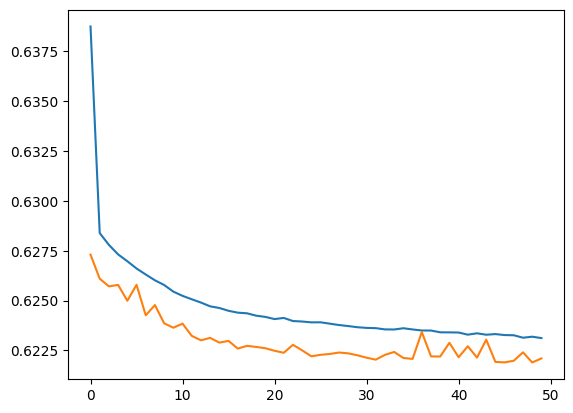

In [16]:
plt.plot(losses,label="train")
plt.plot(val_losses, label="val")

In [18]:
scores = [0.6530, 0.6527, 0.6536, 0.6530, 0.6530]
np.mean(scores), np.std(scores)

(np.float64(0.65306), np.float64(0.00029393876913397617))